In [40]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.factorplots import interaction_plot
from scipy.stats import levene
import geopandas as gpd
import folium
#import matplotlib.pyplot as plt
#import geopandas as gpd



In [41]:
df = pd.read_csv("Datasets/Vaccination_Coverage_among_Young_Children__0-35_Months__20241101.csv")

In [42]:
# Define the state-to-region mapping for the 9 census regions
state_to_region = {
    # Middle Atlantic
    'New York': 'Middle Atlantic', 'NY-Rest of state': 'Middle Atlantic', 'NY-City of New York': 'Middle Atlantic', 
    'New Jersey': 'Middle Atlantic', 'Pennsylvania': 'Middle Atlantic', 
    'PA-Philadelphia': 'Middle Atlantic', 'PA-Rest of state': 'Middle Atlantic',

    # New England
    'Vermont': 'New England', 'New Hampshire': 'New England', 'Massachusetts': 'New England', 
    'Connecticut': 'New England', 'Rhode Island': 'New England', 'Maine': 'New England',

    # East North Central
    'Indiana': 'East North Central', 'Illinois': 'East North Central', 'Michigan': 'East North Central', 
    'Ohio': 'East North Central', 'Wisconsin': 'East North Central', 
    'IL-City of Chicago': 'East North Central', 'IL-Rest of state': 'East North Central',

    # West North Central
    'Iowa': 'West North Central', 'Kansas': 'West North Central', 'Minnesota': 'West North Central',
    'Missouri': 'West North Central', 'Nebraska': 'West North Central', 
    'North Dakota': 'West North Central', 'South Dakota': 'West North Central',

    # South Atlantic
    'Delaware': 'South Atlantic', 'District of Columbia': 'South Atlantic', 'Florida': 'South Atlantic', 
    'Georgia': 'South Atlantic', 'Maryland': 'South Atlantic', 'North Carolina': 'South Atlantic', 
    'South Carolina': 'South Atlantic', 'Virginia': 'South Atlantic', 'West Virginia': 'South Atlantic',

    # East South Central
    'Alabama': 'East South Central', 'Kentucky': 'East South Central', 
    'Mississippi': 'East South Central', 'Tennessee': 'East South Central', 

    # West South Central
    'Arkansas': 'West South Central', 'Louisiana': 'West South Central', 'Oklahoma': 'West South Central', 
    'Texas': 'West South Central', 'TX-City of Houston': 'West South Central', 
    'TX-Rest of state': 'West South Central', 'TX-Dallas County': 'West South Central', 
    'TX-Bexar County': 'West South Central', 'TX-El Paso County': 'West South Central', 
    'TX-Hidalgo County': 'West South Central', 'TX-Tarrant County': 'West South Central',

    # Mountain
    'Arizona': 'Mountain', 'Colorado': 'Mountain', 'Idaho': 'Mountain', 
    'New Mexico': 'Mountain', 'Montana': 'Mountain', 'Utah': 'Mountain', 
    'Nevada': 'Mountain', 'Wyoming': 'Mountain',

    # Pacific
    'Alaska': 'Pacific', 'California': 'Pacific', 'Hawaii': 'Pacific', 
    'Oregon': 'Pacific', 'Washington': 'Pacific'
}


In [43]:
# Filter dataset for DTaP vaccine, relevant years, and rows where 'Dimension Type' is 'Age'
df_filtered = df[
    (df['Vaccine'] == 'DTaP') & 
    (df['Birth Year/Birth Cohort'].str.contains('2020|2021', na=False)) & 
    (df['Dimension Type'] == 'Age')
]


In [44]:

# Map Census Region and handle any unmapped entries as 'Unknown'
df_filtered['Census Region'] = df_filtered['Geography'].map(state_to_region).fillna('Unknown')

# Filter out rows with 'Unknown' regions if they exist
df_filtered = df_filtered[df_filtered['Census Region'] != 'Unknown']

# Extract the age in months from the 'Dimension' column
df_filtered['Age Milestone (months)'] = df_filtered['Dimension'].str.extract(r'(\d+)').astype(float)

# Drop any rows with missing values in relevant columns
df_filtered = df_filtered.dropna(subset=['Age Milestone (months)', 'Census Region', 'Estimate (%)'])

# Convert Estimate (%) to numeric if not already
df_filtered['Estimate (%)'] = pd.to_numeric(df_filtered['Estimate (%)'], errors='coerce')
df_filtered = df_filtered.dropna(subset=['Estimate (%)'])



C:\Users\152ke\AppData\Local\Temp\ipykernel_6220\357962754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Census Region'] = df_filtered['Geography'].map(state_to_region).fillna('Unknown')


In [45]:
# Calculate mean uptake by region
regional_means = df_filtered.groupby('Census Region')['Estimate (%)'].mean().reset_index()

# Rename columns for clarity
regional_means.columns = ['Region', 'Mean_Dtap_Uptake']

# Display the results
print(regional_means)


               Region  Mean_Dtap_Uptake
0  East North Central         84.339643
1  East South Central         83.535000
2     Middle Atlantic         83.825000
3            Mountain         82.799688
4         New England         90.451667
5             Pacific         82.335500
6      South Atlantic         84.520833
7  West North Central         84.985714
8  West South Central         82.726429


In [46]:

# Load the shapefile
shapefile_path = "shapefiles/cb_2018_us_state_500k.shp"
regions_shapefile = gpd.read_file(shapefile_path)


In [47]:
# Add Census Region information to the GeoDataFrame
regions_shapefile['Census Region'] = regions_shapefile['NAME'].map(state_to_region).fillna('Unknown')

# Filter out rows with 'Unknown' regions
regions_shapefile = regions_shapefile[regions_shapefile['Census Region'] != 'Unknown']

# Dissolve states into Census Regions (aggregates by region)
regions_shapefile = regions_shapefile.dissolve(by='Census Region')


In [48]:
# Merge the regional shapefile with vaccination uptake data
choropleth_data = regions_shapefile.merge(regional_means, left_on='Census Region', right_on='Region')


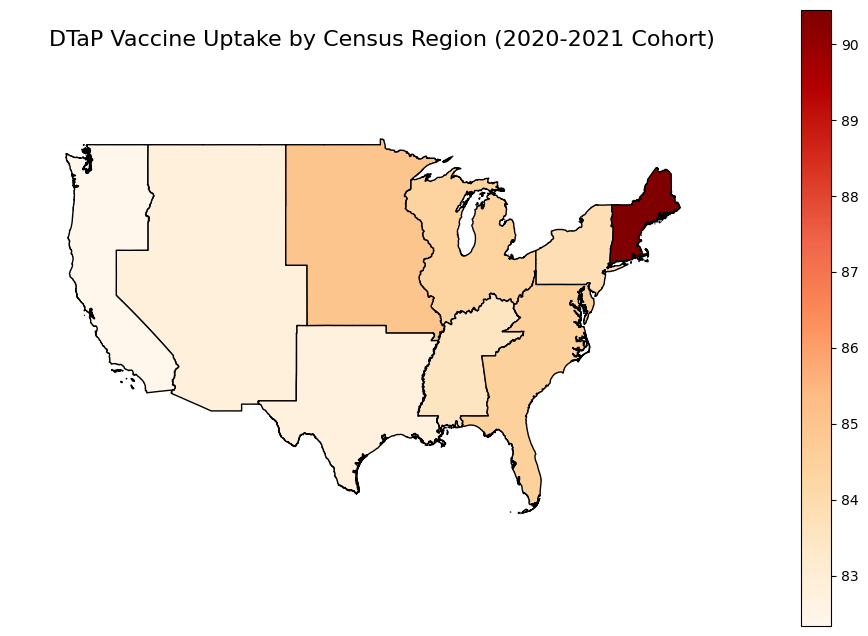

In [49]:


# Plot the choropleth
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
choropleth_data.plot(column='Mean_Dtap_Uptake',
                     cmap='OrRd',  # Color scheme
                     legend=True,
                     ax=ax,
                     edgecolor='black')

# Add a title and labels
ax.set_title('DTaP Vaccine Uptake by Census Region (2020-2021 Cohort)', fontsize=16)
ax.set_axis_off()  # Turn off axis

# Set bounds for the contiguous U.S.
ax.set_xlim([-130, -60])  # Longitude for contiguous U.S.
ax.set_ylim([20, 55])     # Latitude for contiguous U.S.

# Show the plot
plt.show()


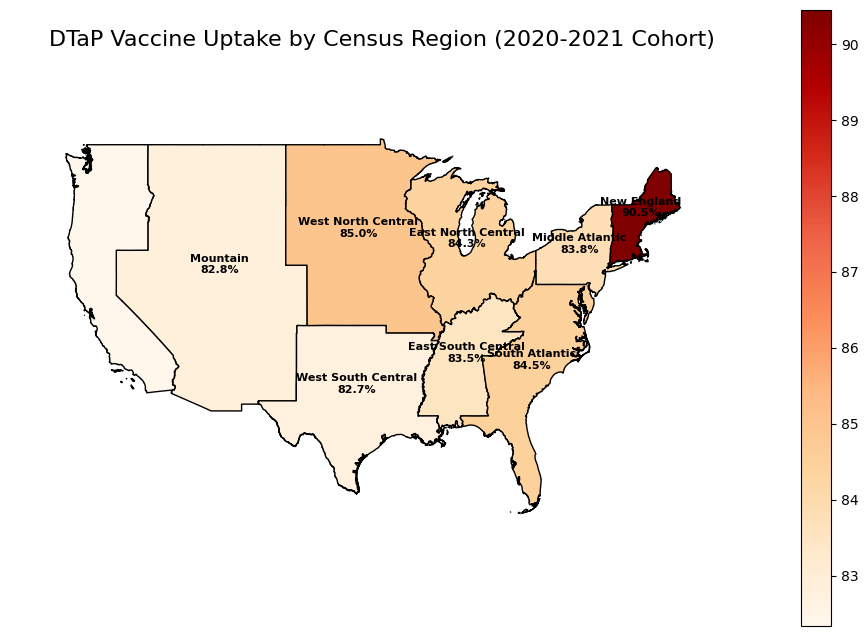

In [54]:
import matplotlib.pyplot as plt

# Plot the choropleth
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
choropleth_data.plot(column='Mean_Dtap_Uptake',
                     cmap='OrRd',  # Color scheme
                     legend=True,
                     ax=ax,
                     edgecolor='black')

# Add a title and turn off axis
ax.set_title('DTaP Vaccine Uptake by Census Region (2020-2021 Cohort)', fontsize=16)
ax.set_axis_off()

# Set bounds for the contiguous U.S.
ax.set_xlim([-130, -60])  # Longitude for contiguous U.S.
ax.set_ylim([20, 55])     # Latitude for contiguous U.S.

# Add labels for each region
for idx, row in choropleth_data.iterrows():
    # Get the centroid of each region
    centroid = row['geometry'].centroid
    # Add annotation with the region name and mean percentage
    ax.annotate(
        f"{row['Region']}\n{row['Mean_Dtap_Uptake']:.1f}%",  # Text with region name and percentage
        xy=(centroid.x, centroid.y),  # Position at the centroid
        fontsize=8,                   # Font size
        fontweight='bold',            # Bold font
        color='black',                # Text color
        ha='center'                   # Center align text
    )

# Show the plot
plt.show()


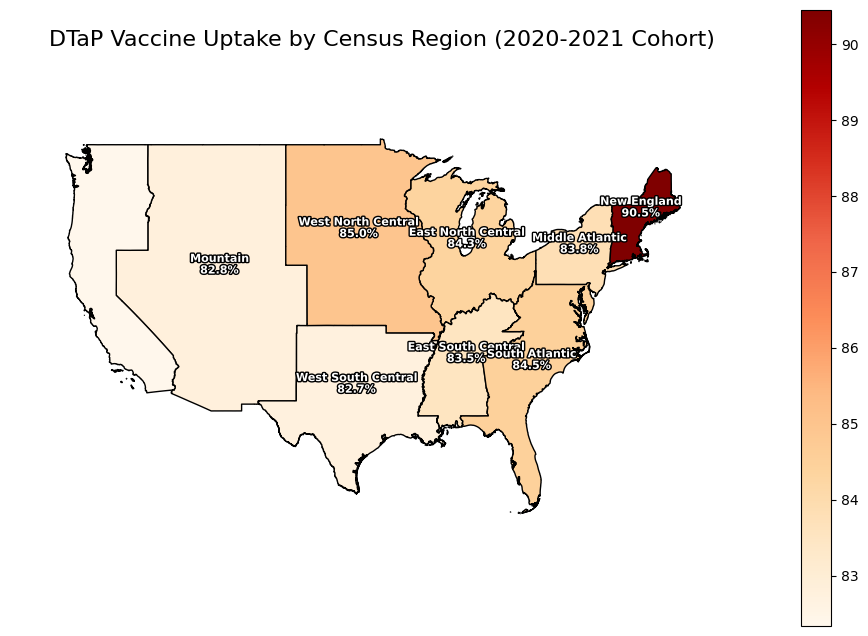

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke  # For text outline effects

# Plot the choropleth
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
choropleth_data.plot(column='Mean_Dtap_Uptake',
                     cmap='OrRd',  # Color scheme
                     legend=True,
                     ax=ax,
                     edgecolor='black')

# Add a title and turn off axis
ax.set_title('DTaP Vaccine Uptake by Census Region (2020-2021 Cohort)', fontsize=16)
ax.set_axis_off()

# Set bounds for the contiguous U.S.
ax.set_xlim([-130, -60])  # Longitude for contiguous U.S.
ax.set_ylim([20, 55])     # Latitude for contiguous U.S.

# Add labels for each region
for idx, row in choropleth_data.iterrows():
    # Get the centroid of each region
    centroid = row['geometry'].centroid
    # Add annotation with the region name and mean percentage
    ax.annotate(
        f"{row['Region']}\n{row['Mean_Dtap_Uptake']:.1f}%",  # Text with region name and percentage
        xy=(centroid.x, centroid.y),  # Position at the centroid
        fontsize=8,                   # Font size
        fontweight='bold',            # Bold font
        color='white',                # Text color
        ha='center',                  # Center align text
        path_effects=[
            withStroke(linewidth=2, foreground="black")  # Bold black outline
        ]
    )

# Show the plot
plt.show()


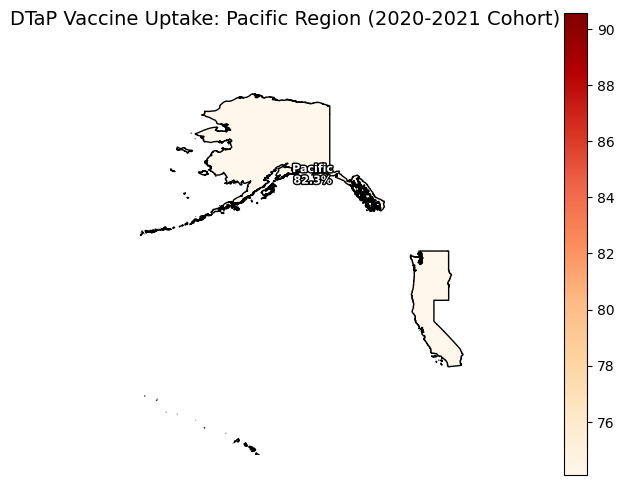

In [57]:
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke  # For text outline effects

# Filter the data for the Pacific region
pacific_data = choropleth_data[choropleth_data['Region'] == 'Pacific']

# Plot the choropleth for the Pacific region
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
pacific_data.plot(
    column='Mean_Dtap_Uptake',
    cmap='OrRd',  # Color scheme
    legend=True,
    ax=ax,
    edgecolor='black'
)

# Add a title and turn off axis
ax.set_title('DTaP Vaccine Uptake: Pacific Region (2020-2021 Cohort)', fontsize=14)
ax.set_axis_off()

# Add labels for the Pacific region
for idx, row in pacific_data.iterrows():
    # Get the centroid of the region
    centroid = row['geometry'].centroid
    # Add annotation with the region name and mean percentage
    ax.annotate(
        f"{row['Region']}\n{row['Mean_Dtap_Uptake']:.1f}%",  # Text with region name and percentage
        xy=(centroid.x, centroid.y),  # Position at the centroid
        fontsize=8,                   # Font size
        fontweight='bold',            # Bold font
        color='white',                # Text color
        ha='center',                  # Center align text
        path_effects=[
            withStroke(linewidth=2, foreground="black")  # Bold black outline
        ]
    )

# Adjust bounds to zoom in on the Pacific region
ax.set_xlim([-200, -100])  # Adjust these values to better fit the Pacific region
ax.set_ylim([20, 80])      # Adjust these values to better fit the Pacific region

# Show the plot
plt.show()
